In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
import matplotlib
%matplotlib inline

In [5]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)

In [7]:
import utils; reload(utils)
from utils import plots

### Create Train, Validation and Subsample Set

In [ ]:
%cd /home/ubuntu/data/fisheries/
%mkdir validation
%mkdir validation/ALB
%mkdir validation/BET
%mkdir validation/NoF
%mkdir validation/YFT
%mkdir validation/OTHER
%mkdir validation/SHARK
%mkdir validation/DOL
%mkdir validation/LAG

In [ ]:
import os
import shutil

In [ ]:
train_folder = "/home/ubuntu/data/fisheries/train/"
val_folder = "/home/ubuntu/data/fisheries/validation/"
folders = os.listdir(train_folder)

for f in folders:
    if not f.startswith("."):
        shuf = np.random.permutation(os.listdir(train_folder + f))
        select = int(len(shuf)*0.2)
        for i in shuf[:select]:
            shutil.move(train_folder + f + "/" + i, val_folder + f + "/" + i)

### Actual deep net

In [1]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

Preprocess the images to fit the VGG16 format

In [8]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [9]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [10]:
model = VGG_16()

In [ ]:
model.summary()

Get the pre-trained weights

In [11]:
FILES_PATH = 'http://www.platform.ai/models/'
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')

553328640/553482496 [============================>.] - ETA: 0s

In [12]:
model.load_weights(fpath)

## PREDICTIONS

In [18]:
batch_size = 4
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory('/home/ubuntu/data/fisheries/'+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 3025 images belonging to 8 classes.
Found 752 images belonging to 8 classes.


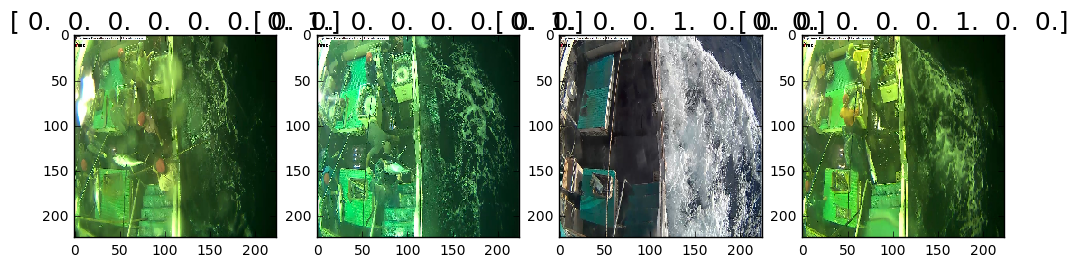

In [20]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('validation', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [21]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

Get the 1000 class descriptions from imagenet in order to know what class is predicted

In [22]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

16384/35363 [============>.................] - ETA: 0s

In [23]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.0542e-05   8.5571e-04   1.7108e-04   1.7660e-04   3.1732e-04]

Predictions prob/class: 
  0.2077/beer_bottle
  0.3784/pay-phone
  0.2470/dam
  0.1300/beer_bottle


### Train classifier on top
We already have the model, so we first get the predictions for 1000 classes, then train the classifier n top

In [24]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [25]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [26]:
val_batches = get_batches('validation', shuffle=False, batch_size=32)
batches = get_batches('train', shuffle=False, batch_size=32)

Found 752 images belonging to 8 classes.
Found 3025 images belonging to 8 classes.


Save pre-processed data as arrays to skip this step in the future

In [27]:
from utils import plots, get_batches, plot_confusion_matrix, get_data
trn_data = get_data('/home/ubuntu/data/fisheries/train')
trn_data.shape

Found 3025 images belonging to 8 classes.


(3025, 3, 224, 224)

This is just for saving the trn_data arrays to skip the previous step. Helpful when using a slow system

In [ ]:
import bcolz
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [63]:
type(trn_data)
with open("./data/subsample/preprocessed_subsample_images.npy", 'wb') as f:
    trn_data.tofile(f)

In [ ]:
with open("./data/subsample/preprocessed_subsample_images.npy", 'rb') as f:
    trn_data = np.load(f)

From discrete classes [ 7,7,5,6,...] to one-hot encoding 

In [28]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [29]:
trn_classes = batches.classes
trn_labels = onehot(trn_classes)

In [30]:
print(trn_classes.shape)
print(trn_classes[390:])
print(trn_labels)

(3025,)
[0 0 0 ..., 7 7 7]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Now make predictions from the pre-trained model (vector with length 1000)

In [31]:
trn_features = model.predict(trn_data, batch_size=batch_size)

In [32]:
print(trn_features.shape)

(3025, 1000)


In [33]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(8, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
lm.fit(trn_features, trn_labels, nb_epoch=5, batch_size=32)

Epoch 1/5
3025/3025 [==============================] - 0s - loss: 0.6584 - acc: 0.7726     
Epoch 2/5
3025/3025 [==============================] - 0s - loss: 0.6280 - acc: 0.7871     
Epoch 3/5
3025/3025 [==============================] - 0s - loss: 0.6041 - acc: 0.7931     
Epoch 4/5
3025/3025 [==============================] - 0s - loss: 0.5834 - acc: 0.7967     
Epoch 5/5
3025/3025 [==============================] - 0s - loss: 0.5665 - acc: 0.8152     


In [37]:
subs_preds = lm.predict(trn_features, batch_size=batch_size)

In [45]:
print(subs_preds[:5])

[[  6.6331e-01   1.2522e-02   3.8241e-03   4.2391e-06   4.1330e-03   2.7493e-01   3.7629e-02
    3.6446e-03]
 [  8.6366e-01   1.4247e-02   6.1786e-05   9.7326e-03   4.1193e-02   2.7049e-03   1.9628e-08
    6.8398e-02]
 [  5.3407e-01   3.9338e-03   2.3698e-06   4.7948e-02   2.9666e-02   3.7991e-01   3.5014e-17
    4.4654e-03]
 [  8.2289e-01   1.9569e-03   1.2902e-04   8.2435e-02   1.9318e-02   2.8274e-02   3.8312e-12
    4.4998e-02]
 [  7.3742e-01   2.2142e-03   1.3400e-04   1.3838e-06   4.8590e-02   1.4528e-02   5.2111e-02
    1.4500e-01]]


### Make a Kaggle submission

In [46]:
model.add(lm)

In [50]:
# make predistions on the test set
#test_batches = get_batches("./data/test", shuffle=False, batch_size = 24, class_mode=None)
test_preds = model.predict_generator(val_batches, val_batches.nb_sample)

In [51]:
print(test_preds[:5])

[[  4.7026e-07   2.1819e-02   2.1379e-04 ...,   1.2263e-07   1.4415e-05   1.2258e-05]
 [  5.2462e-05   3.5160e-04   2.8569e-02 ...,   1.8074e-07   4.5513e-05   5.2286e-05]
 [  1.8458e-05   1.2661e-04   2.2529e-02 ...,   1.8687e-06   2.7705e-06   8.2807e-06]
 [  2.2659e-05   1.9803e-04   5.4614e-04 ...,   4.9869e-08   6.6187e-05   2.9148e-05]
 [  1.8330e-04   2.4548e-03   4.1499e-02 ...,   1.9967e-06   6.2053e-06   3.6918e-04]]


In [63]:
filenames = val_batches.filenames
print(filenames[:5])
print(test_preds.shape)
print(np.array(filenames).shape)

['ALB/img_04220.jpg', 'ALB/img_06439.jpg', 'ALB/img_06393.jpg', 'ALB/img_02664.jpg', 'ALB/img_01804.jpg']
(752, 1000)
(752,)


In [65]:
subm = np.stack([filenames, test_preds], axis=1)

ValueError: all input arrays must have the same shape

In [ ]:
np.savetxt('test_submission.csv', subm, header="image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT")